In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 10 August 2024


"""
v1.0 08 March 2025
Paper Version

Load full GNSS data for selected stations.
Find instantaneous velocity and smooth.
Plot figure 6
"""

# Imports
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.timeseries import LombScargle

import pandas as pd
import numpy as np
import scipy


import pyTMD.io
import pyTMD.time
import timescale

In [2]:
# Load data for selected stations
# Zachary Katz
# zachary_katz@mines.edu
# October 2024

# Make input for LEASTSQUARESGMT.sh

# Imports
import sys
import logging

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/e/csrs_2024/all" 
stas =  ["la02","la07","la10","gz01"
        ]
#year_arr = [["2007","2008","2009"],["2016","2017","2018","2019"]]
year_arr = [["2007","2008","2009","2010","2011","2012",'2013','2014','2015',"2016","2017","2018","2019"]]
#year_arr = [["2019"]]
# Detection parameters
max_gap_len = 120 # 24 hr # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 2 # Minimum number of stations needed for an event

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 

# Path to Catalog
# Default {pwd}/src/Catalog
path = "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Catalog"
# fmt: on
########################## User Defined Variables ##############################
################################################################################

sys.path.insert(
    0,
    path,
)


def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [3]:
import Catalog


# Find instantaneous velocity and smooth
def derivative(time, x_col, freq):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of

    Returns
    grad - First derivative [list]
    grad2 - Second derivative [list]
    """
    y_data = x_col - np.mean(x_col)
    # print(x_data,y_data)
    try:
        b, a = scipy.signal.butter(4, freq, "low")
        filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
        grad = np.gradient(filtered, 15)

        b, a = scipy.signal.butter(4, 0.05)
        grad_filtered = scipy.signal.filtfilt(b, a, grad, padlen=50)
        grad2 = np.gradient(np.gradient(grad_filtered), 15)
    except ValueError:
        grad = np.full(len(y_data), np.nan)
        grad2 = np.full(len(y_data), np.nan)
    return grad, grad2

In [4]:
# Aprox 30 min
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")
    picks = Catalog.Picks(cats)

    picks.lls_detection_no_res(window, slide)
    sorted_list = picks.on_off_list()

2025-03-08 16:24:24 __main__ INFO: Creating Dataframe for la02
2025-03-08 16:57:21 __main__ INFO: Interpolating la02
2025-03-08 16:57:24 Catalog INFO: 2010-04-03 04:49:15 2010-04-03 04:49:45 0 days 00:00:30
2025-03-08 16:57:31 Catalog INFO: 2010-04-29 23:29:00 2010-04-29 23:30:00 0 days 00:01:00
2025-03-08 16:57:38 Catalog INFO: 2010-04-29 23:33:15 2010-04-29 23:34:30 0 days 00:01:15
2025-03-08 16:57:44 Catalog INFO: 2010-04-29 23:35:15 2010-04-29 23:36:15 0 days 00:01:00
2025-03-08 16:58:07 Catalog INFO: 2010-10-05 16:00:45 2010-10-05 16:02:30 0 days 00:01:45
2025-03-08 16:58:44 Catalog INFO: 2012-04-29 22:24:45 2012-04-29 22:26:00 0 days 00:01:15
2025-03-08 16:59:04 Catalog INFO: 2013-01-26 04:42:00 2013-01-26 04:42:45 0 days 00:00:45
2025-03-08 16:59:10 Catalog INFO: 2013-01-26 05:06:15 2013-01-26 05:08:00 0 days 00:01:45
2025-03-08 16:59:15 Catalog INFO: 2013-01-26 05:08:45 2013-01-26 05:09:30 0 days 00:00:45
2025-03-08 16:59:20 Catalog INFO: 2013-02-02 07:59:45 2013-02-02 08:00:30

In [5]:
sta_dfs = []
for sta in picks.stas:
    dfs = []
    _start = sorted_list[sorted_list["station"] == sta.name]
    start = _start[_start["onset"]]
    _end = sorted_list[sorted_list["station"] == sta.name]
    end = _start[_start["onset"] == False]  # noqa: E712

    for st, ed in zip(start["times"], end["times"]):
        st_index = sta.data[sta.data["time"] == st].index[0]
        ed_index = sta.data[sta.data["time"] == ed].index[0]
        df = sta.data[st_index:ed_index]
        g1, g2 = derivative(df["time"], df["x"], 0.05)
        df["velocity"] = g1
        dfs.append(df)

    sta_dfs.append(dfs)

/tmp/ipykernel_450368/285035420.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["velocity"] = g1
/tmp/ipykernel_450368/285035420.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["velocity"] = g1
/tmp/ipykernel_450368/285035420.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [ ]:
# Compute XX day rolling average of velocity
# Find 45 days in terms of 15 sec observations
# 45 days * 24 hours * 60 minutes * 60 seconds / 15 seconds


# Change between 3, 45 and rerun from here to get figs S6 an S7
days = 45
obs_num = int(days * 24 * 60 * 60 / 15)
for sta in sta_dfs:
    for df in sta:
        df["velocity_30"] = (
            df["velocity"]
            .rolling(window=obs_num, center=True, min_periods=obs_num - 1000)
            .mean()
        )  # m / sec
        df["velocity_30"] = df["velocity_30"] * 3600 * 24 * 365  # m / year

/tmp/ipykernel_450368/3947981081.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["velocity_30"] = (
/tmp/ipykernel_450368/3947981081.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["velocity_30"] = df["velocity_30"] * 3600 * 24 * 365  # m / year


In [21]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv(f"../AllEventStartTimes_{min_stas}stas.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Find times with no data
no_data = {"interval": [], "starts": [], "ends": []}
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        if diff > datetime.timedelta(days=2):
            no_data["starts"].append(ev_data["ev_time"][i - 1])
            no_data["ends"].append(ev_data["ev_time"][i])
            no_data["interval"].append(diff)


def tides(dates, lat, lon):
    """
    Calcs tides at times for 1 location lat,lon
    times must be in datetime format
    lat, lon floats

    Returns tides in cm
    """
    years = np.array([date.year for date in dates])
    months = np.array([date.month for date in dates])
    days = np.array([date.day for date in dates])
    hours = np.array([date.hour for date in dates])
    minutes = np.array([date.minute for date in dates])

    dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    mod = "CATS2008-v2023"
    model = pyTMD.io.model(dir, format="netcdf").elevation(mod)

    # Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )
    print(model.format)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lon),
        np.atleast_1d(lat),
        constituents,
        model.projection,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    # calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    MINOR = pyTMD.predict.infer_minor(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    return TIDE.data

In [22]:
# Tide time series at gz05
spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2008-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 11 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]


for lat, lon, place in zip(lats, lons, places):
    ev_data[f"tides{place}"] = tides(dates_timeseries, lat, lon)

TMD3


In [9]:
# Connect axes using https://matplotlib.org/stable/users/explain/text/annotations.html
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch,
    BboxConnector,
    BboxConnectorPatch,
)


def connect_bbox(
    bbox1, bbox2, loc1a, loc2a, loc1b, loc2b, prop_lines, prop_patches=None
):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1) * 0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(
        bbox1,
        bbox2,
        # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        loc1a=loc1a,
        loc2a=loc2a,
        loc1b=loc1b,
        loc2b=loc2b,
        **prop_patches,
    )
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=2,
        loc1b=4,
        loc2b=1,
        prop_lines=kwargs,
        prop_patches=prop_patches,
    )

    # ax1.add_patch(bbox_patch1)
    # ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

In [18]:
# Spectrograms
i = 0
avg_vel_detrendeds = []
dates_as_secs = []
for i in [0, 1, 2, 3]:
    sta_df = pd.concat(sta_dfs[i])
    dates_as_sec = [a.timestamp() for a in sta_df["time"]]
    avg_vel_masked = np.ma.masked_array(
        sta_df["velocity_30"], mask=np.invert(~np.isnan(sta_df["velocity_30"]))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(sta_df["velocity_30"]))
    )

    avg_vel_masked = np.ma.compressed(avg_vel_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    avg_vel_detrended = scipy.signal.detrend(avg_vel_masked)
    avg_vel_detrendeds.append(avg_vel_detrended)
    dates_as_secs.append(dates_as_sec_masked)

In [19]:
# Downsample to make lomb-scargle tractable
dates_as_secs_downsampled = []
avg_vel_detrendeds_downsampled = []
# Downsample to every 6 hours
# 6 hours * 60 minutes * 60 seconds / 15 seconds = 144
for i in range(4):
    dates_as_secs_downsampled.append(dates_as_secs[i][::180])
    avg_vel_detrendeds_downsampled.append(avg_vel_detrendeds[i][::180])

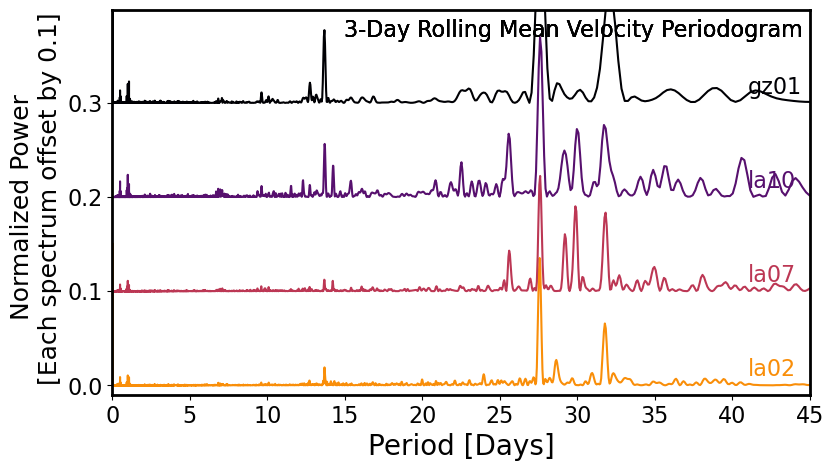

In [ ]:
##########
# FIGURE 5
##########

# Spectrogram of rolling avg slips using lomb scargle
fig, ax = plt.subplots(figsize=(9, 5))
offset = 0
colors = ["#f98e09", "#bc3754", "#57106e", "#000004"]
stas = ["la02", "la07", "la10", "gz01"]
for avg_vel_detrended, dates_as_sec_masked, color, sta in zip(
    avg_vel_detrendeds_downsampled, dates_as_secs_downsampled, colors, stas
):
    frequency, power = LombScargle(dates_as_sec_masked, avg_vel_detrended).autopower()
    pks = scipy.signal.find_peaks(power, height=0.02)[0]
    # ax.plot(frequency[pks], power[pks], 'ro')
    period = 1 / frequency / 3600 / 24  # days
    ax.plot(period, power + offset, color=color, label=sta)
    ax.text(41, offset + 0.01, sta, color=color, fontsize=16)
    offset += 0.1
    ax.text(
        0.99,
        0.93,
        "3-Day Rolling Mean Velocity Periodogram",
        transform=ax.transAxes,
        fontsize=16,
        horizontalalignment="right",
    )
    ax.set_xlabel("Period [Days]", fontsize=20)
    ax.set_ylabel("Normalized Power \n [Each spectrum offset by 0.1]", fontsize=18)
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 0.399)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    SEC_TO_DAY = 3600 * 24
    SEC_TO_HR = 3600
    # for pk, pwr in zip(frequency[pks], power[pks]):
    # if pk < 0.25e-5:
    # print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
    # else:
    # print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
    # print("")

fig.savefig("Figure5.png", dpi=300)

/tmp/ipykernel_450368/354017001.py:146: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


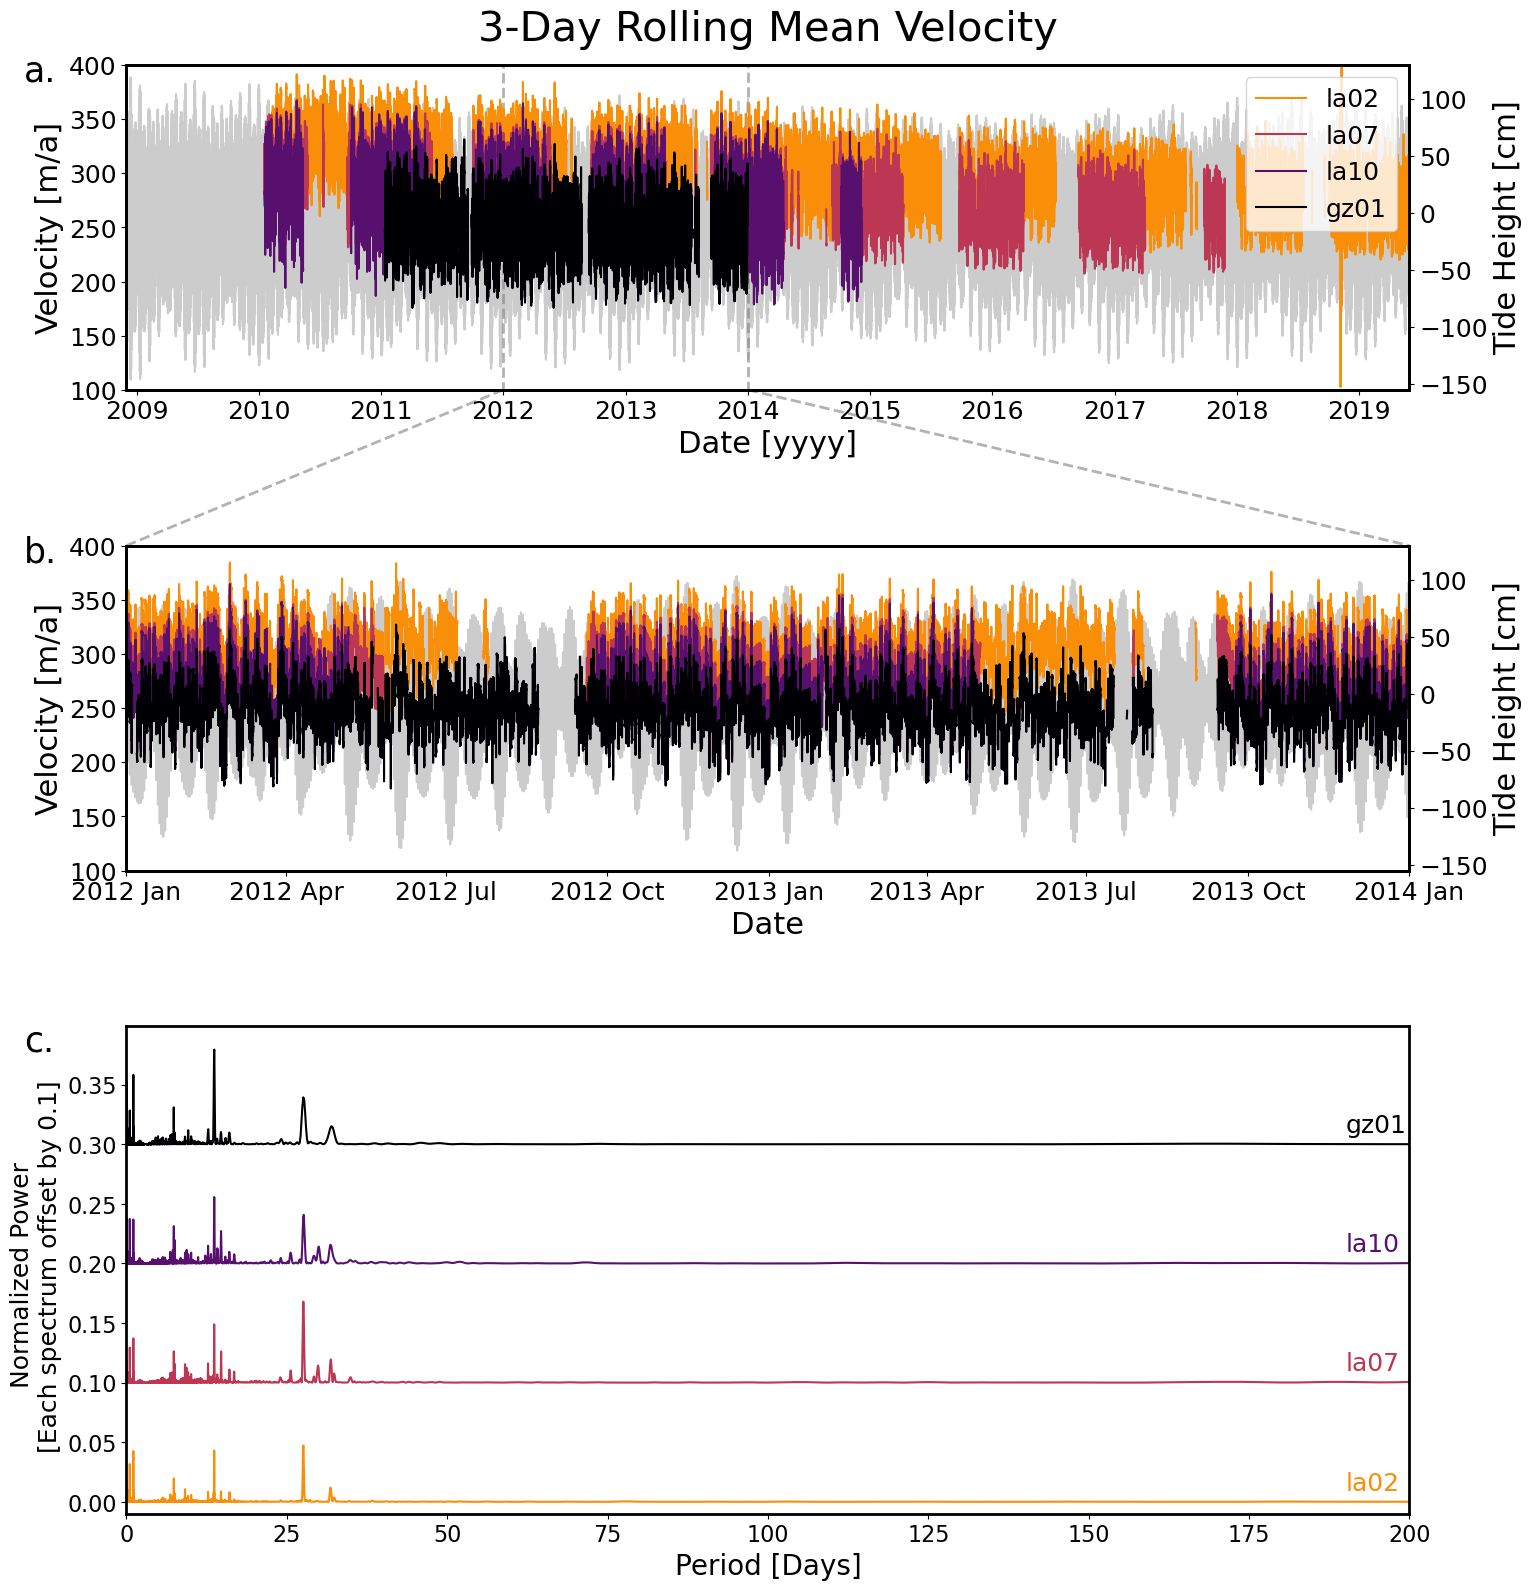

In [ ]:
###########
# Figure S6
# Figure S7
###########

stas = ["la02", "la07", "la10", "gz01"]
fig = plt.figure(
    figsize=[16, 16],
    constrained_layout=True,
)
gs = mpl.gridspec.GridSpec(
    3, 2, figure=fig, width_ratios=[0.9, 0.03], height_ratios=[1, 1, 1.5]
)
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[2, 0])

# Switch axes limits for S6, S7
y_min = 100  # 240  # 100
y_max = 400  # 340  # 400

# colors = ["#f5db4c", "#f78410", "#cb4149", "#85216b", "#390963", "#000004"]
colors = [
    "#f98e09",
    "#bc3754",
    "#57106e",
    "#000004",
]

(ax1.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    # ax1.add_patch(rect)
ax1.set_ylim(-155, 130)

ax2 = ax1.twinx()

for p, sta in enumerate(sta_dfs):
    for q, df in enumerate(sta):
        if q == 0:
            ax2.plot(df["time"], df["velocity_30"], label=stas[p], color=colors[p])
        else:
            ax2.plot(df["time"], df["velocity_30"], color=colors[p])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax1.set_xlabel("Date [yyyy]", size=22)
ax1.set_ylabel("Tide Height [cm]", size=22)
ax2.set_ylabel("Velocity [m/a]", size=22)
ax2.set_ylim(y_min, y_max)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.legend(fontsize=18, loc="upper right")
ax1.set_xlim(datetime.datetime(2008, 12, 1), datetime.datetime(2019, 6, 1))
# ax1.text(0.99,0.93, f"{days}-Day Rolling Mean Velocity", transform=ax1.transAxes, fontsize=16,horizontalalignment='right')

(ax3.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    # ax1.add_patch(rect)
ax3.set_ylim(-155, 130)
ax4 = ax3.twinx()

for p, sta in enumerate(sta_dfs):
    for q, df in enumerate(sta):
        if q == 0:
            ax4.plot(df["time"], df["velocity_30"], label=stas[p], color=colors[p])
        else:
            ax4.plot(df["time"], df["velocity_30"], color=colors[p])

ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax4.yaxis.set_label_position("left")
ax4.yaxis.tick_left()
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))

ax3.set_xlabel("Date", size=22)
ax3.set_ylabel("Tide Height [cm]", size=22)
ax4.set_ylabel("Velocity [m/a]", size=22)

ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)
st = datetime.datetime(2012, 1, 1)
ed = datetime.datetime(2014, 1, 1)

ax3.set_xlim(st, ed)
rect = plt.Rectangle(
    (st, -200),
    ed - st,
    1000,
    facecolor="none",
    zorder=0,
    alpha=0.3,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
)
ax1.add_patch(rect)
ax4.set_ylim(y_min, y_max)

zoom_effect01(
    ax1,
    ax3,
    mdates.date2num(st),
    mdates.date2num(ed),
    ec="black",
    lw=2,
    alpha=0.3,
    ls="--",
)

offset = 0
colors = ["#f98e09", "#bc3754", "#57106e", "#000004"]
stas = ["la02", "la07", "la10", "gz01"]
for avg_vel_detrended, dates_as_sec_masked, color, sta in zip(
    avg_vel_detrendeds_downsampled, dates_as_secs_downsampled, colors, stas
):
    frequency, power = LombScargle(dates_as_sec_masked, avg_vel_detrended).autopower()
    pks = scipy.signal.find_peaks(power, height=0.02)[0]
    # ax.plot(frequency[pks], power[pks], 'ro')
    period = 1 / frequency / 3600 / 24  # days
    ax5.plot(period, power + offset, color=color, label=sta)
    ax5.text(190, offset + 0.01, sta, color=color, fontsize=18)
    offset += 0.1
    ax5.set_xlabel("Period [Days]", fontsize=20)
    ax5.set_ylabel("Normalized Power \n [Each spectrum offset by 0.1]", fontsize=18)
    ax5.set_xlim(0, 200)
    ax5.set_ylim(-0.01, 0.399)
    ax5.xaxis.set_tick_params(labelsize=16)
    ax5.yaxis.set_tick_params(labelsize=16)


ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax3.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax5.annotate("c.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax1.set_title(f"{days}-Day Rolling Mean Velocity", fontsize=30, y=1.05)
fig.tight_layout()
if days == 3:
    fig.savefig("FigureS6.png", dpi=300)
else:
    fig.savefig("FigureS7.png", dpi=300)